In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Init

In [2]:
path = 'C:/Users/robin.opdam/Google Drive/Thesis (Msc)/Thesis_shared_files/'
# path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'

---
# Compare Results

In [33]:
file_names = ['ml_1m', 'am_like_ml']#, 'am_20k_users']
titles = ['MovieLens 1m', 'Am-like-ML']#, 'Amazon 20k Users']

In [34]:
def read_cfrnn(file_name):
    df = pd.read_pickle(path + 'Logs/final/' + file_name + '_neumf_log')

In [35]:
def read_neumf(file_name):
    df = pd.read_pickle(path + 'Logs/final/' + file_name + '_neumf_log')
    df['train_loss'] = [l['loss'] for l in df.NeuMF]
    return df

## All metrics comparison

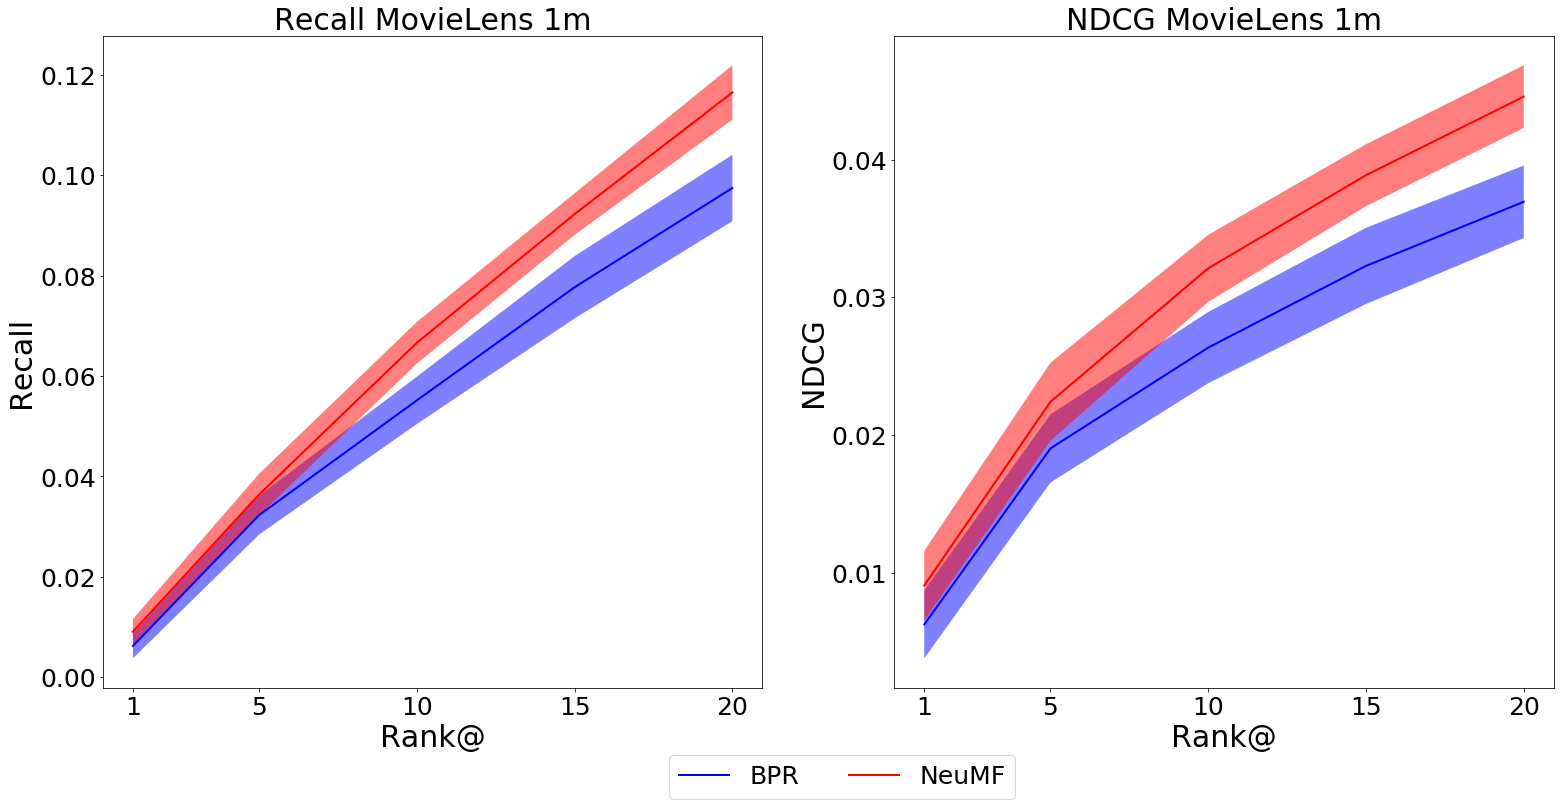

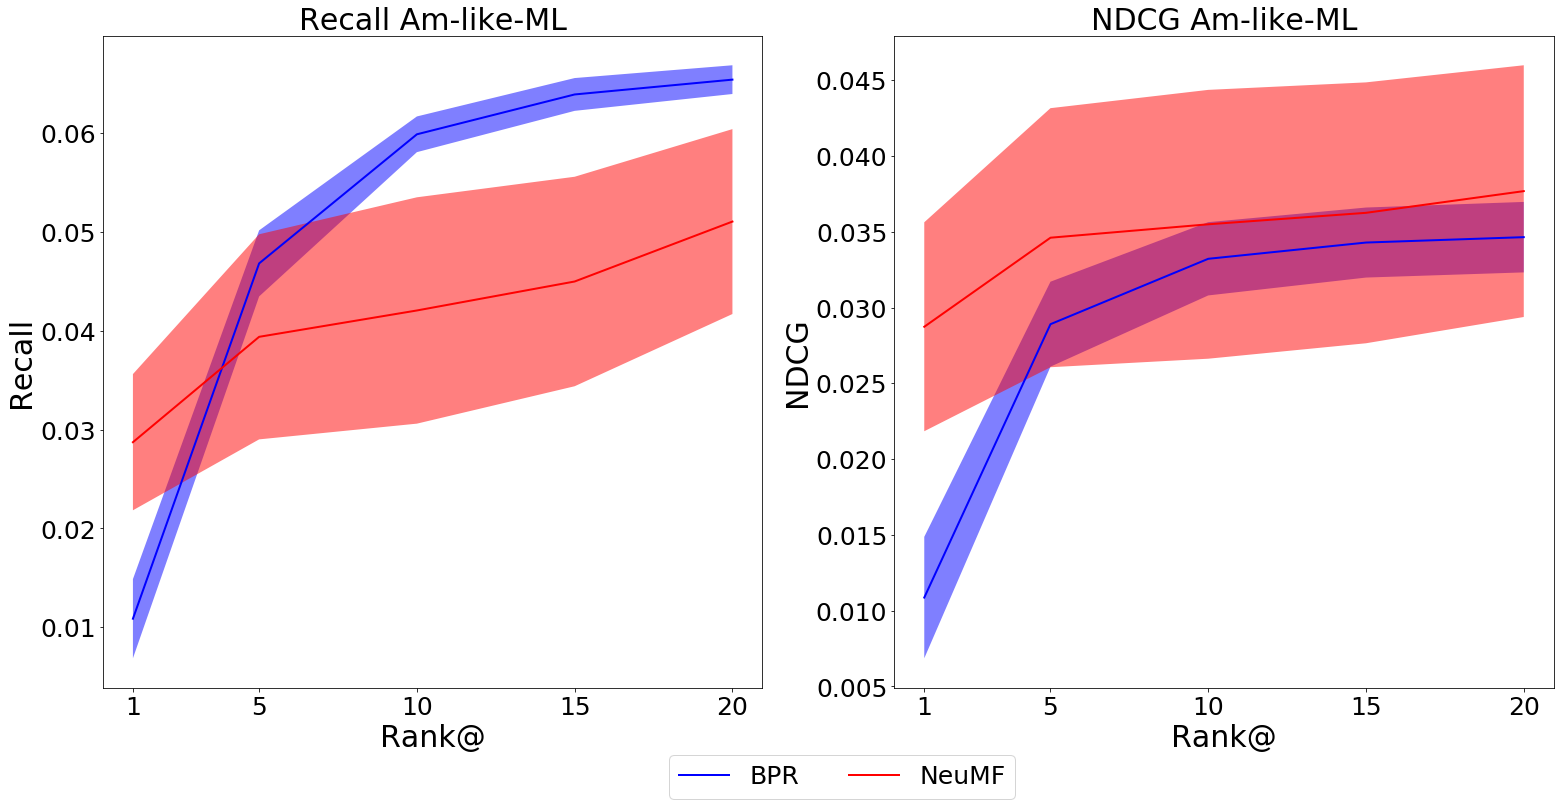

In [36]:
from Evaluation import get_final_results
from visualize_results import plot_final_metrics

final_results = {'metrics':{}, 'stats':{'bpr':[], 'cfrnn':[], 'neumf':[]}, 'time':[]}
for file_name, title in zip(file_names, titles):
    bpr = pd.read_pickle(path + 'Logs/final/' + file_name + '_bpr_log')
    # cfrnn = read_cfrnn(file_name)
    neumf = read_neumf(file_name)
    results = [bpr, neumf]#, cfrnn_ml_1m, neumf_ml_1m]
    final_results['metrics'][file_name] = []
    
    for res, name in zip(results, final_results['stats'].keys()):
        final_metrics, train_stats, train_time = get_final_results(res)
        final_results['metrics'][file_name].append(final_metrics)
        final_results['stats'][name].append(train_stats)
        final_results['time'].append(train_time)
    
    colors = ['blue', 'red']
    labels = ['BPR', 'NeuMF']
    metrics_to_show = ['recall', 'ndcg']
    plot_final_metrics(final_results['metrics'][file_name], colors, labels, metrics_to_show, title)

## BPR Train Stats

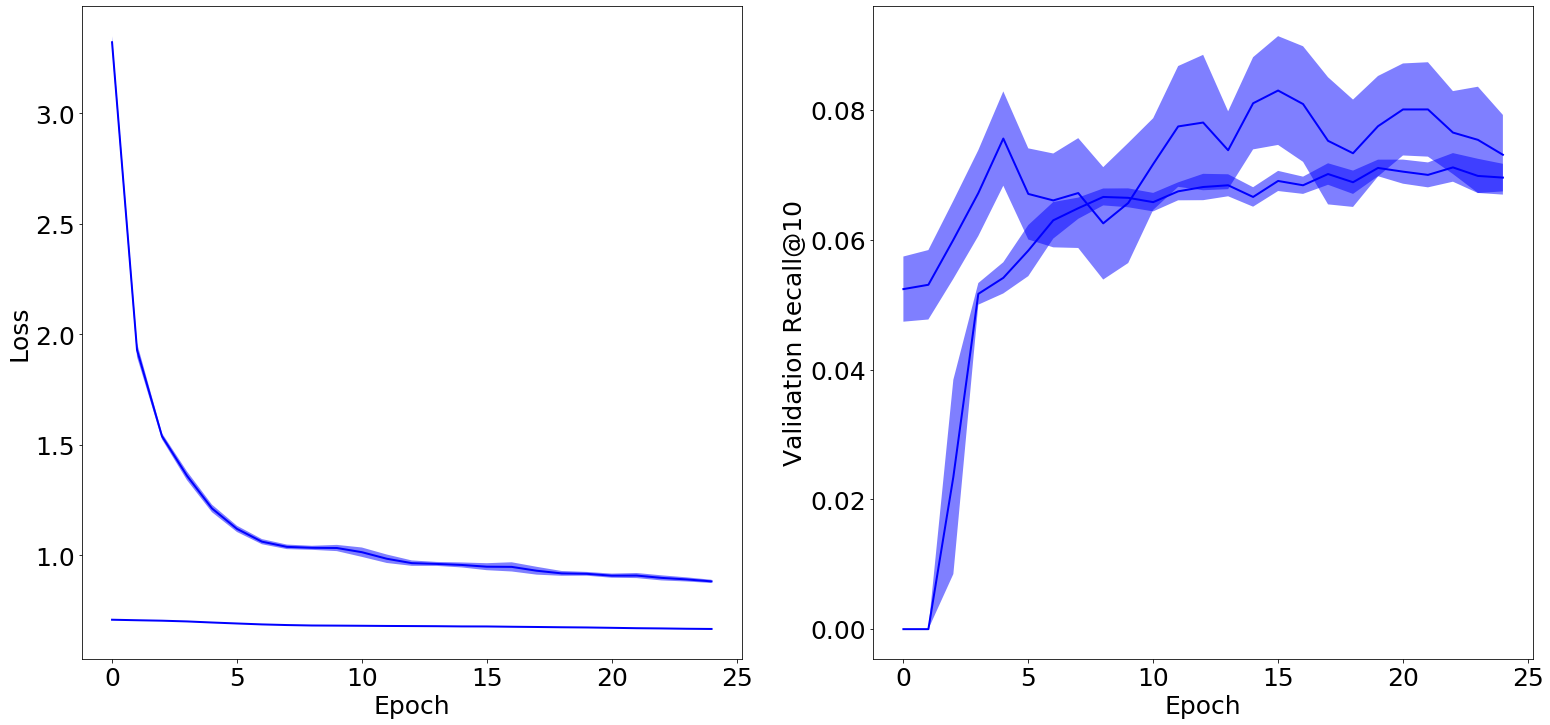

In [38]:
from visualize_results import plot_train_stats
plot_train_stats(final_results['stats']['bpr'], color='blue', size=(26,12))

## CFRNN Train Stats

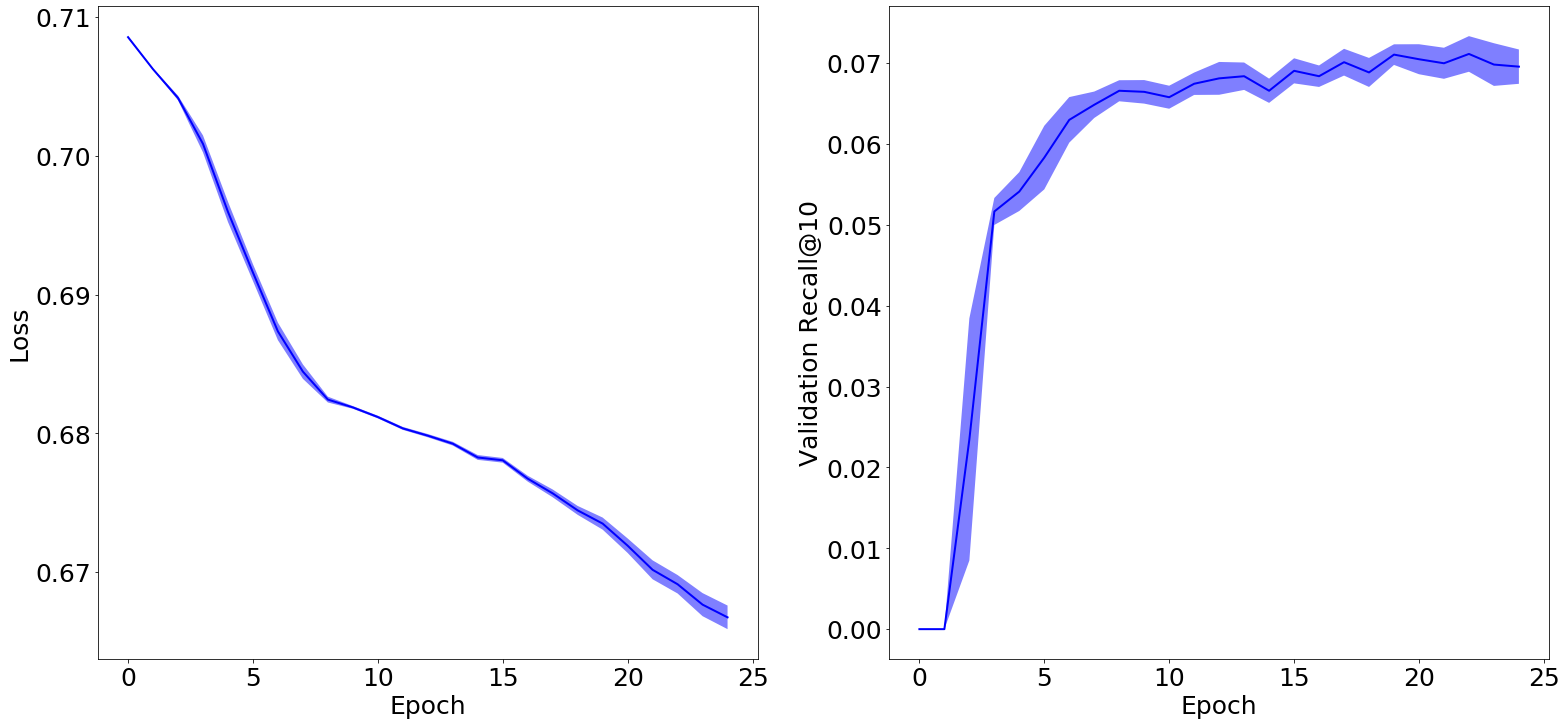

In [90]:
plot_train_stats(final_results['stats'][0], color='blue', size=(26,12))

## NeuMF Train Stats

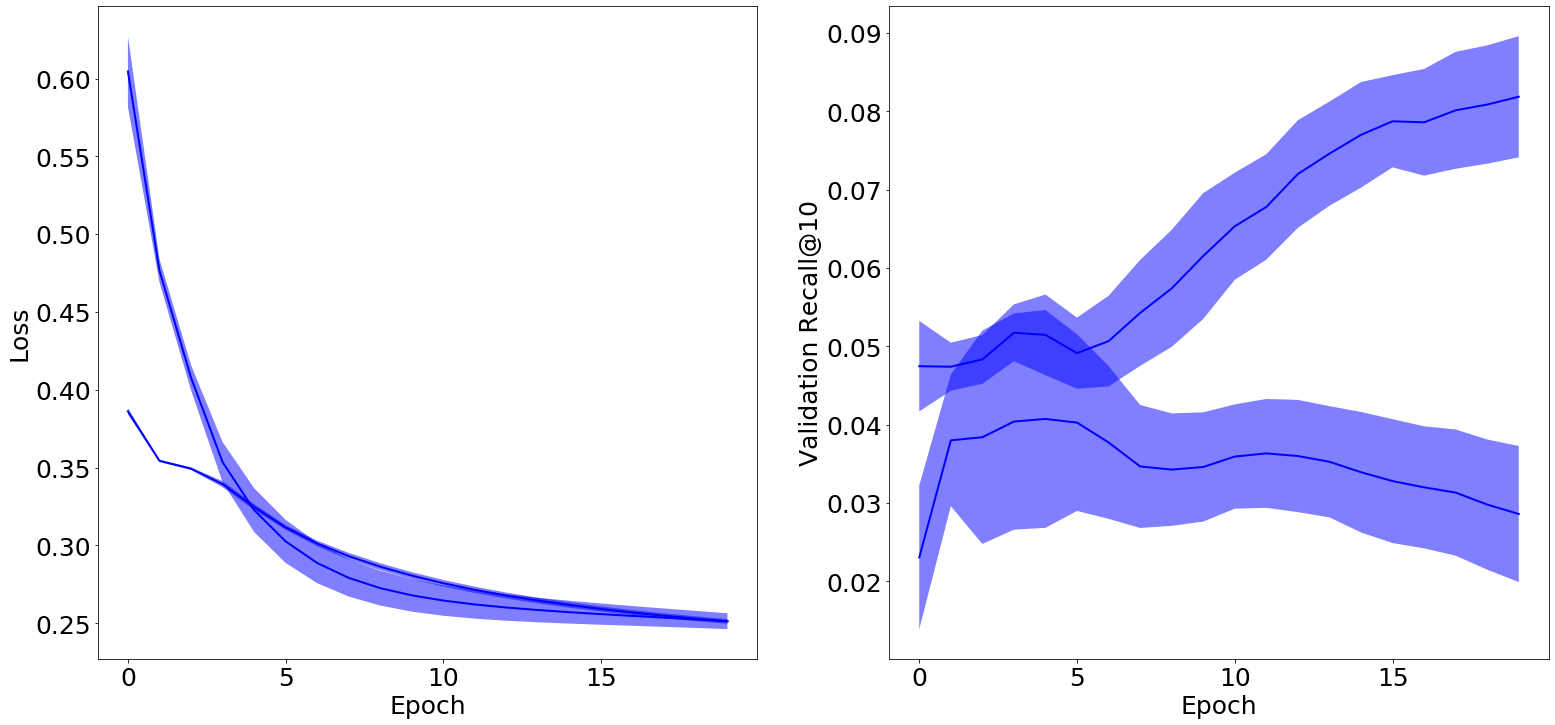

In [41]:
plot_train_stats(final_results['stats']['cfrnn'], color='blue', size=(26,12))

In [40]:
final_results

{'metrics': {'ml_1m': [   recall_mean  hitcounts_mean  ndcg_mean  recall_std  hitcounts_std  \
   0     0.006233        6.233333   0.006233    0.002459       2.459091   
   1     0.032300       32.300000   0.019025    0.003870       3.869866   
   2     0.055167       55.166667   0.026352    0.004713       4.713029   
   3     0.077700       77.700000   0.032290    0.006204       6.204281   
   4     0.097467       97.466667   0.036951    0.006611       6.611032   
   
      ndcg_std  rank_at  
   0  0.002459        1  
   1  0.002473        5  
   2  0.002586       10  
   3  0.002770       15  
   4  0.002632       20  ,
      recall_mean  hitcounts_mean  ndcg_mean  recall_std  hitcounts_std  \
   0     0.009067        9.066667   0.009067    0.002518       2.517981   
   1     0.036400       36.400000   0.022420    0.004132       4.132295   
   2     0.066633       66.633333   0.032114    0.004148       4.147981   
   3     0.092267       92.266667   0.038880    0.004152       4.1517